In [7]:
import pandas as pd


df = pd.read_csv('/home/hyuksu/projects/ml/project/데이터/FIN_DATA_v4.csv',encoding='utf-8')
df

,DATE_YM,STATES,SIZE,PRICE_MEDIAN,COUNTS,PRICE_MEDIAN_LAG_1,PRICE_MEDIAN_LAG_2,PRICE_MEDIAN_LAG_3,CPI,BASE_RATE,...,BASE_RATE_LAG_2,CPI_YOY_LAG_2,REAL_RATE_LAG_2,HOUSE_RATE_LAG_2,CPI_LAG_3,BASE_RATE_LAG_3,CPI_YOY_LAG_3,REAL_RATE_LAG_3,HOUSE_RATE_LAG_3,VARIABLED
0,201504,강남구,대형,128750.0,246,130000.0,125000.0,132750.0,94.625,1.730,...,1.990,0.645882,1.344118,3.0,94.643,1.990,0.974074,1.015926,3.0,-0.030132
1,201505,강남구,대형,133000.0,204,128750.0,130000.0,125000.0,94.890,1.740,...,1.820,0.470511,1.349489,2.0,94.587,1.990,0.645882,1.344118,3.0,0.064000
2,201506,강남구,대형,131000.0,183,133000.0,128750.0,130000.0,94.909,1.570,...,1.730,0.436241,1.293759,2.0,94.596,1.820,0.470511,1.349489,2.0,0.007692
3,201507,강남구,대형,139250.0,176,131000.0,133000.0,128750.0,95.080,1.480,...,1.740,0.552088,1.187912,3.0,94.625,1.730,0.436241,1.293759,2.0,0.081553
4,201508,강남구,대형,135000.0,157,139250.0,131000.0,133000.0,95.213,1.490,...,1.570,0.701341,0.868659,3.0,94.890,1.740,0.552088,1.187912,3.0,0.015038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4567,202506,중구,중형,120000.0,86,134500.0,120000.0,125000.0,116.310,2.520,...,2.769,2.078765,0.690235,3.0,116.290,2.754,2.053532,0.700468,4.0,-0.040000
4568,202507,중구,중형,115000.0,20,120000.0,134500.0,120000.0,116.520,2.500,...,2.738,1.901840,0.836160,3.0,116.380,2.769,2.078765,0.690235,3.0,-0.041667
4569,202508,중구,중형,129000.0,25,115000.0,120000.0,134500.0,116.450,2.506,...,2.520,2.169712,0.350288,3.0,116.270,2.738,1.901840,0.836160,3.0,-0.040892
4570,202509,중구,중형,137500.0,69,129000.0,115000.0,120000.0,117.060,2.526,...,2.500,2.094103,0.405897,3.0,116.310,2.520,2.169712,0.350288,3.0,0.145833


In [4]:
# ===============================
# 0. 기본 import
# ===============================
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture


# ===============================
# 1. 데이터 준비
# df 는 이미 read로 만들어져 있다고 가정
# ===============================

df = df.copy()

# 날짜, 현재값 제거
drop_cols = ["DATE_YM", "PRICE_MEDIAN"]
X = df.drop(columns=drop_cols)


# ===============================
# 2. 컬럼 타입 분리
# ===============================

cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(exclude="object").columns.tolist()


# ===============================
# 3. 전처리 파이프라인
# ===============================

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("log_cnt", FunctionTransformer(np.log1p), ["COUNTS"]),
        ("num", "passthrough", [c for c in num_cols if c != "COUNTS"]),
    ]
)


# ===============================
# 4. GMM 파이프라인
# ===============================

gmm_pipeline = Pipeline([
    ("prep", preprocess),
    ("scaler", StandardScaler(with_mean=False)),  # OHE 때문에 False
    ("gmm", GaussianMixture(
        n_components=3,          # 일단 3개 상태
        covariance_type="full",
        random_state=42
    ))
])


# ===============================
# 5. 시간순 train / test 분리
# ===============================

split_idx = int(len(X) * 0.73)

X_train = X.iloc[:split_idx]
X_test  = X.iloc[split_idx:]


# ===============================
# 6. 학습
# ===============================

gmm_pipeline.fit(X_train)


# ===============================
# 7. 클러스터 결과
# ===============================

train_cluster = gmm_pipeline.predict(X_train)
test_cluster  = gmm_pipeline.predict(X_test)

train_prob = gmm_pipeline.predict_proba(X_train)
test_prob  = gmm_pipeline.predict_proba(X_test)


# ===============================
# 8. 결과 DF 확인
# ===============================

train_result = df.iloc[:split_idx].copy()
train_result["cluster"] = train_cluster

print(train_result.groupby("cluster")["VARIABLED"].describe())


          count      mean       std       min       25%       50%       75%  \
cluster                                                                       
0         806.0  0.027319  0.206574 -0.648649 -0.056777  0.012381  0.090153   
1        2063.0  0.047394  0.177268 -0.731544 -0.025135  0.034120  0.095757   
2         468.0  0.043458  0.457384 -0.821579 -0.138607 -0.016487  0.119969   

              max  
cluster            
0        2.911765  
1        2.479167  
2        4.117647  


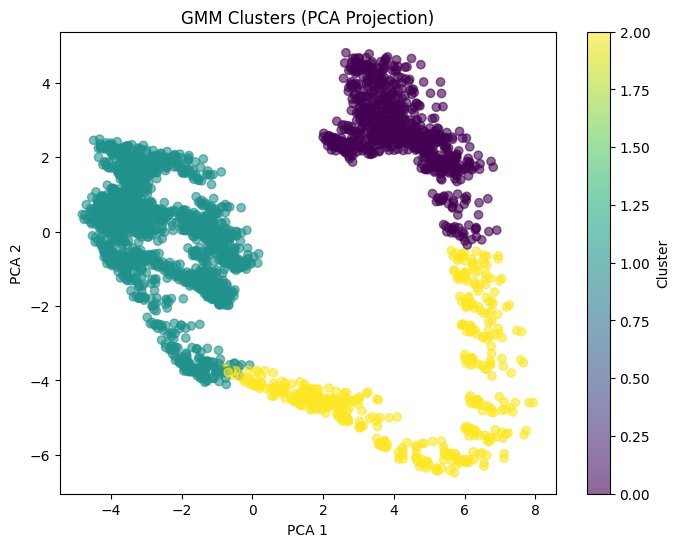

In [5]:
# ===============================
# 9. PCA로 2D 시각화
# ===============================
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# 1) 전처리 + 스케일링된 데이터 얻기
X_train_transformed = gmm_pipeline.named_steps["scaler"].transform(
    gmm_pipeline.named_steps["prep"].transform(X_train)
)

# 2) PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_train_transformed)

# 3) 시각화
plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=train_cluster,
    alpha=0.6
)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("GMM Clusters (PCA Projection)")
plt.colorbar(label="Cluster")
plt.show()


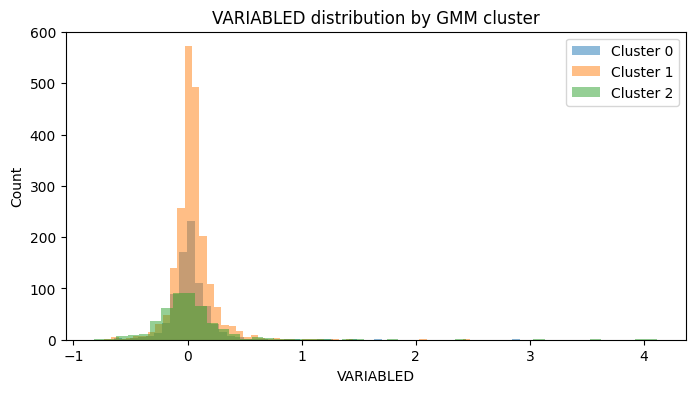

In [6]:
plt.figure(figsize=(8, 4))
for c in sorted(train_result["cluster"].unique()):
    subset = train_result[train_result["cluster"] == c]["VARIABLED"]
    plt.hist(subset, bins=50, alpha=0.5, label=f"Cluster {c}")

plt.legend()
plt.title("VARIABLED distribution by GMM cluster")
plt.xlabel("VARIABLED")
plt.ylabel("Count")
plt.show()


In [8]:
# ===============================
# 0. import
# ===============================
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture


# ===============================
# 1. 데이터 준비
# ===============================
df = df.copy()

# DATE_YM만 제거
X = df.drop(columns=["DATE_YM"])


# ===============================
# 2. 컬럼 타입 분리
# ===============================
cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(exclude="object").columns.tolist()


# ===============================
# 3. 전처리
# ===============================
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("log_cnt", FunctionTransformer(np.log1p), ["COUNTS"]),
        ("num", "passthrough", [c for c in num_cols if c != "COUNTS"]),
    ]
)


# ===============================
# 4. GMM 파이프라인
# ===============================
gmm_pipeline = Pipeline([
    ("prep", preprocess),
    ("scaler", StandardScaler(with_mean=False)),
    ("gmm", GaussianMixture(
        n_components=3,          # 일단 3
        covariance_type="full",
        random_state=42
    ))
])


# ===============================
# 5. 시간순 분리
# ===============================
split_idx = int(len(X) * 0.73)

X_train = X.iloc[:split_idx]
X_test  = X.iloc[split_idx:]


# ===============================
# 6. 학습
# ===============================
gmm_pipeline.fit(X_train)


# ===============================
# 7. 클러스터 결과
# ===============================
train_cluster = gmm_pipeline.predict(X_train)
test_cluster  = gmm_pipeline.predict(X_test)

train_prob = gmm_pipeline.predict_proba(X_train)


# ===============================
# 8. 결과 확인
# ===============================
train_result = df.iloc[:split_idx].copy()
train_result["cluster"] = train_cluster

print(train_result.groupby("cluster")["VARIABLED"].describe())


          count      mean       std       min       25%       50%       75%  \
cluster                                                                       
0         806.0  0.027319  0.206574 -0.648649 -0.056777  0.012381  0.090153   
1        2063.0  0.047394  0.177268 -0.731544 -0.025135  0.034120  0.095757   
2         468.0  0.043458  0.457384 -0.821579 -0.138607 -0.016487  0.119969   

              max  
cluster            
0        2.911765  
1        2.479167  
2        4.117647  


[BIC best K] 9
[AIC best K] 9


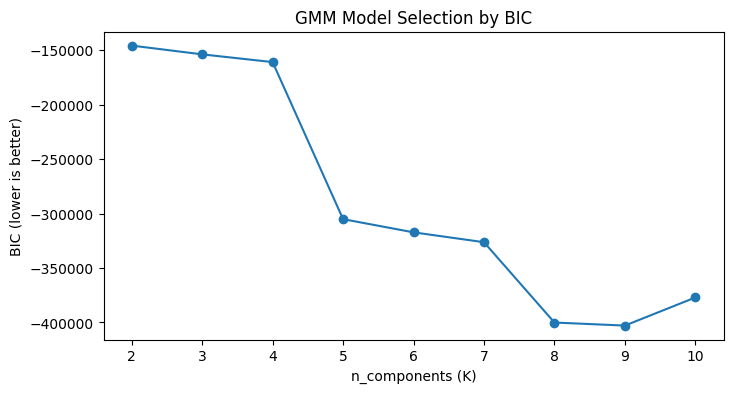

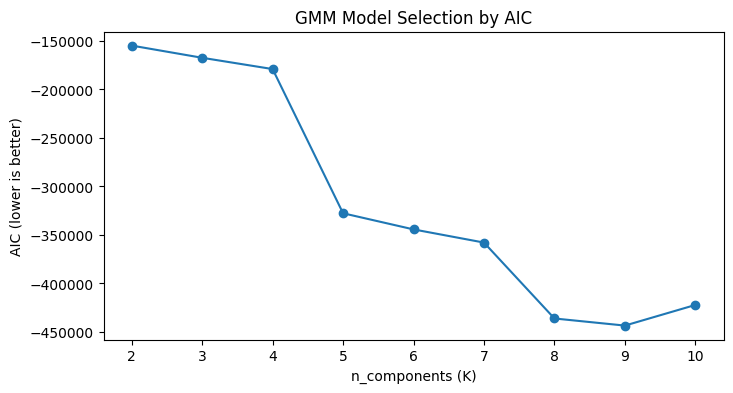


[Train] y(VARIABLED) by cluster
            count      mean       std       min       25%       50%       75%  \
gmm_label                                                                       
0           170.0  0.024045  0.123741 -0.404545 -0.047091  0.016387  0.077054   
1           168.0  0.032289  0.260195 -0.638034 -0.122171  0.028143  0.141850   
2           300.0  0.046664  0.197133 -0.645078 -0.039751  0.036342  0.107168   
3           136.0  0.156734  0.783607 -0.821579 -0.219551 -0.013968  0.252171   
4           210.0  0.029728  0.241898 -0.648649 -0.075000  0.005280  0.103515   
5           742.0  0.027228  0.130012 -0.526870 -0.019950  0.022187  0.069191   
6          1071.0  0.054072  0.218180 -0.731544 -0.047194  0.036145  0.126502   
7           377.0  0.023068  0.103409 -0.331081 -0.025352  0.020900  0.070370   
8           163.0  0.013810  0.199969 -0.648980 -0.062589  0.000000  0.104296   

                max  
gmm_label            
0          0.444643  
1        

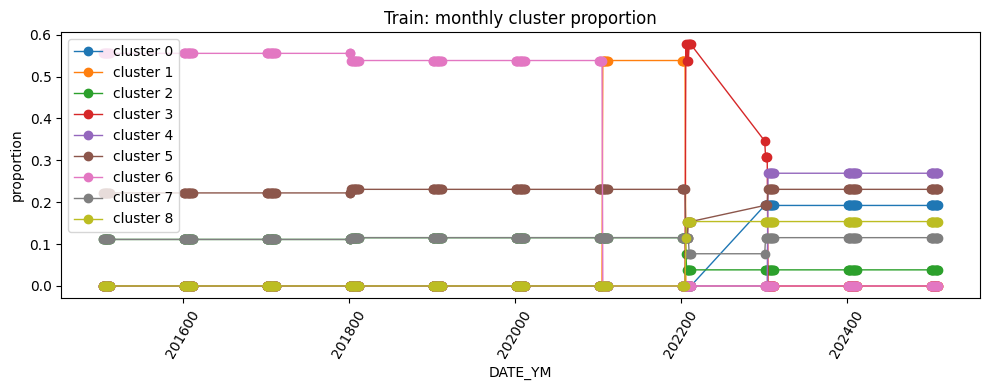


[SVR + GMM features]
MAE=0.199991 RMSE=0.362110 R2=0.194583


In [9]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import SVR

import matplotlib.pyplot as plt


# =========================
# 0) 기본 설정
# =========================
df = df.copy()
target = "VARIABLED"

# 시간순 split (너가 쓰던 비율 그대로)
split_idx = int(len(df) * 0.73)

# -------------------------
# GMM에 넣을 X (중요)
#  - DATE_YM 제외 (숫자 시간 오해 방지)
#  - target VARIABLED 제외 (SVR에 쓸 feature 만들 거라 누수 방지)
# -------------------------
X_gmm = df.drop(columns=["DATE_YM", target])

# (선택) PRICE_MEDIAN 포함/제외
# 현재시점 가격레벨도 상태(레짐) 판단에 의미 있으니 포함해도 OK
# 만약 너가 PRICE_MEDIAN이 찝찝하면 아래 줄로 제거
# X_gmm = X_gmm.drop(columns=["PRICE_MEDIAN"])


# =========================
# 1) GMM: BIC/AIC로 최적 K 선택
# =========================
cat_cols = X_gmm.select_dtypes(include="object").columns.tolist()
num_cols = X_gmm.select_dtypes(exclude="object").columns.tolist()

preprocess_gmm = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("log_cnt", FunctionTransformer(np.log1p), ["COUNTS"]),
        ("num", "passthrough", [c for c in num_cols if c != "COUNTS"]),
    ]
)

# 전처리+스케일 (GMM은 스케일 민감)
prep_scale = Pipeline([
    ("prep", preprocess_gmm),
    ("scaler", StandardScaler(with_mean=False))
])

X_train_gmm = X_gmm.iloc[:split_idx]
X_test_gmm  = X_gmm.iloc[split_idx:]

Z_train = prep_scale.fit_transform(X_train_gmm)
Z_test  = prep_scale.transform(X_test_gmm)

# K 후보들 (적당히 2~10 정도부터)
Ks = list(range(2, 11))
bics, aics = [], []

for k in Ks:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type="full",
        random_state=42
    )
    gmm.fit(Z_train)
    bics.append(gmm.bic(Z_train))
    aics.append(gmm.aic(Z_train))

best_k_bic = Ks[int(np.argmin(bics))]
best_k_aic = Ks[int(np.argmin(aics))]

print(f"[BIC best K] {best_k_bic}")
print(f"[AIC best K] {best_k_aic}")

# 시각화
plt.figure(figsize=(8,4))
plt.plot(Ks, bics, marker="o")
plt.xlabel("n_components (K)")
plt.ylabel("BIC (lower is better)")
plt.title("GMM Model Selection by BIC")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(Ks, aics, marker="o")
plt.xlabel("n_components (K)")
plt.ylabel("AIC (lower is better)")
plt.title("GMM Model Selection by AIC")
plt.show()

# 여기서는 BIC를 기본 선택으로
best_k = best_k_bic


# =========================
# 2) 선택된 K로 GMM 학습 + 클러스터 해석
# =========================
gmm_final = GaussianMixture(
    n_components=best_k,
    covariance_type="full",
    random_state=42
)
gmm_final.fit(Z_train)

train_label = gmm_final.predict(Z_train)
test_label  = gmm_final.predict(Z_test)

train_prob = gmm_final.predict_proba(Z_train)
test_prob  = gmm_final.predict_proba(Z_test)

# 결과 DF에 라벨 붙이기 (DATE_YM은 해석/시각화용으로만 사용)
train_result = df.iloc[:split_idx].copy()
test_result  = df.iloc[split_idx:].copy()

train_result["gmm_label"] = train_label
test_result["gmm_label"]  = test_label

# (2-1) 클러스터별 y 분포 확인 (훈련구간 기준)
print("\n[Train] y(VARIABLED) by cluster")
print(train_result.groupby("gmm_label")[target].describe())

# (2-2) 자치구(STATES) 분포: 클러스터별 TOP 10
print("\n[Train] STATES count by cluster (top 10 each)")
for c in sorted(train_result["gmm_label"].unique()):
    top_states = train_result[train_result["gmm_label"] == c]["STATES"].value_counts().head(10)
    print(f"\nCluster {c} TOP STATES:\n{top_states}")

# (2-3) SIZE 분포: 클러스터별 비율
print("\n[Train] SIZE ratio by cluster")
size_ratio = (train_result.groupby("gmm_label")["SIZE"]
              .value_counts(normalize=True)
              .rename("ratio")
              .reset_index())
print(size_ratio)

# (2-4) 시간에 따라 레짐이 어떻게 바뀌는지 (월별 클러스터 비율)
train_time_mix = (train_result.groupby("DATE_YM")["gmm_label"]
                  .value_counts(normalize=True)
                  .unstack(fill_value=0)
                  .sort_index())

plt.figure(figsize=(10,4))
for c in train_time_mix.columns:
    plt.plot(train_time_mix.index, train_time_mix[c], marker="o", linewidth=1, label=f"cluster {c}")
plt.title("Train: monthly cluster proportion")
plt.xlabel("DATE_YM")
plt.ylabel("proportion")
plt.xticks(rotation=60)
plt.legend()
plt.tight_layout()
plt.show()


# =========================
# 3) GMM 결과(확률/라벨)를 feature로 만들어 SVR에 넣기
# =========================
# 전체 데이터에 대해 GMM feature 생성
Z_all = prep_scale.transform(X_gmm)                 # 주의: prep_scale은 train에 fit된 상태
prob_all = gmm_final.predict_proba(Z_all)
label_all = np.argmax(prob_all, axis=1)

df_feat = df.copy()
df_feat["gmm_label"] = label_all

# 확률 feature들 (gmm_p0, gmm_p1, ...)
for i in range(best_k):
    df_feat[f"gmm_p{i}"] = prob_all[:, i]

# -------------------------
# SVR용 X/y 구성
#  - DATE_YM 제외
#  - y = VARIABLED
#  - (권장) PRICE_MEDIAN은 누수 위험은 낮지만, 네가 이전에 baseline 비교할 때 뺐으니 기본은 제거
# -------------------------
y = df_feat[target]

X_svr = df_feat.drop(columns=["DATE_YM", target])

# (권장 기본) PRICE_MEDIAN 제거: lag들로 흐름만 쓰고 싶으면
if "PRICE_MEDIAN" in X_svr.columns:
    X_svr = X_svr.drop(columns=["PRICE_MEDIAN"])

# train/test 시간순 분리
X_train = X_svr.iloc[:split_idx]
X_test  = X_svr.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

# 전처리 (SVR)
cat_cols_svr = X_train.select_dtypes(include="object").columns.tolist()
num_cols_svr = X_train.select_dtypes(exclude="object").columns.tolist()

preprocess_svr = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_svr),
        ("log_cnt", FunctionTransformer(np.log1p), ["COUNTS"]),
        ("num", "passthrough", [c for c in num_cols_svr if c != "COUNTS"]),
    ]
)

svr_model = Pipeline([
    ("prep", preprocess_svr),
    ("scaler", StandardScaler(with_mean=False)),
    ("svr", SVR(kernel="rbf", C=10.0, epsilon=0.1, gamma="scale"))
])

svr_model.fit(X_train, y_train)
pred = svr_model.predict(X_test)

mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

print("\n[SVR + GMM features]")
print(f"MAE={mae:.6f} RMSE={rmse:.6f} R2={r2:.6f}")


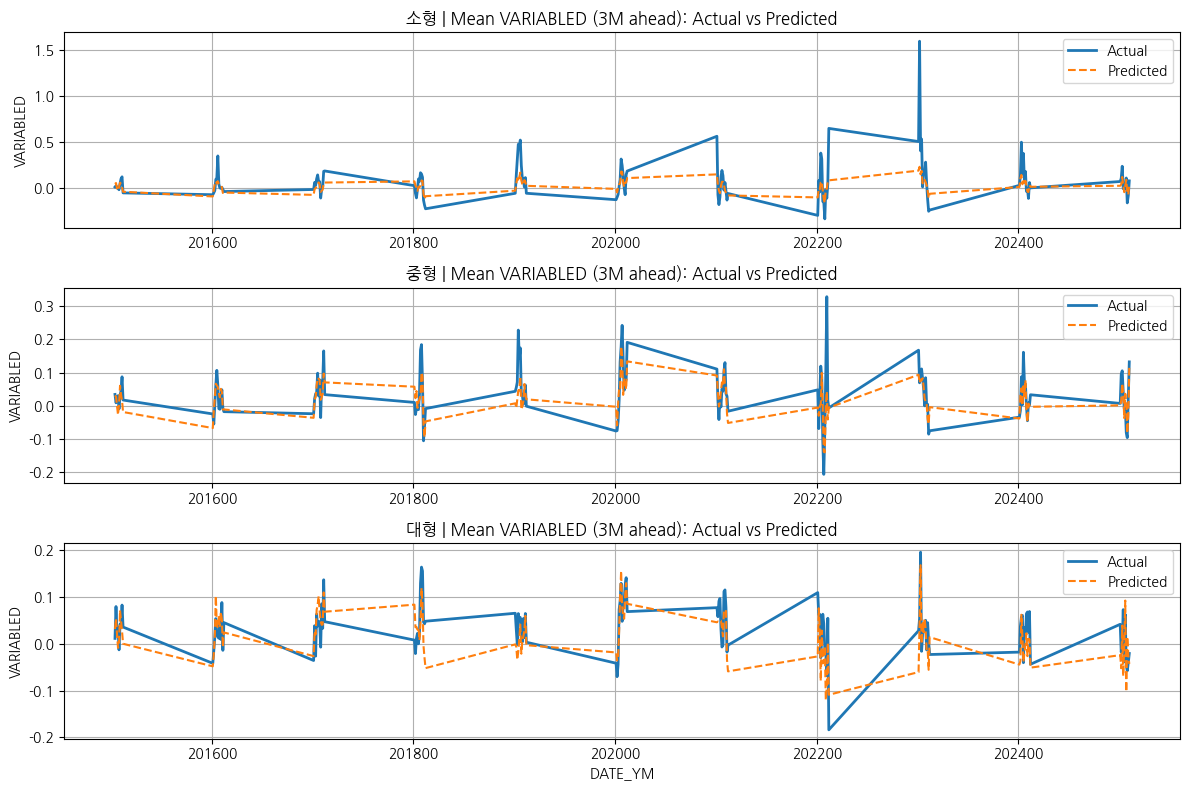

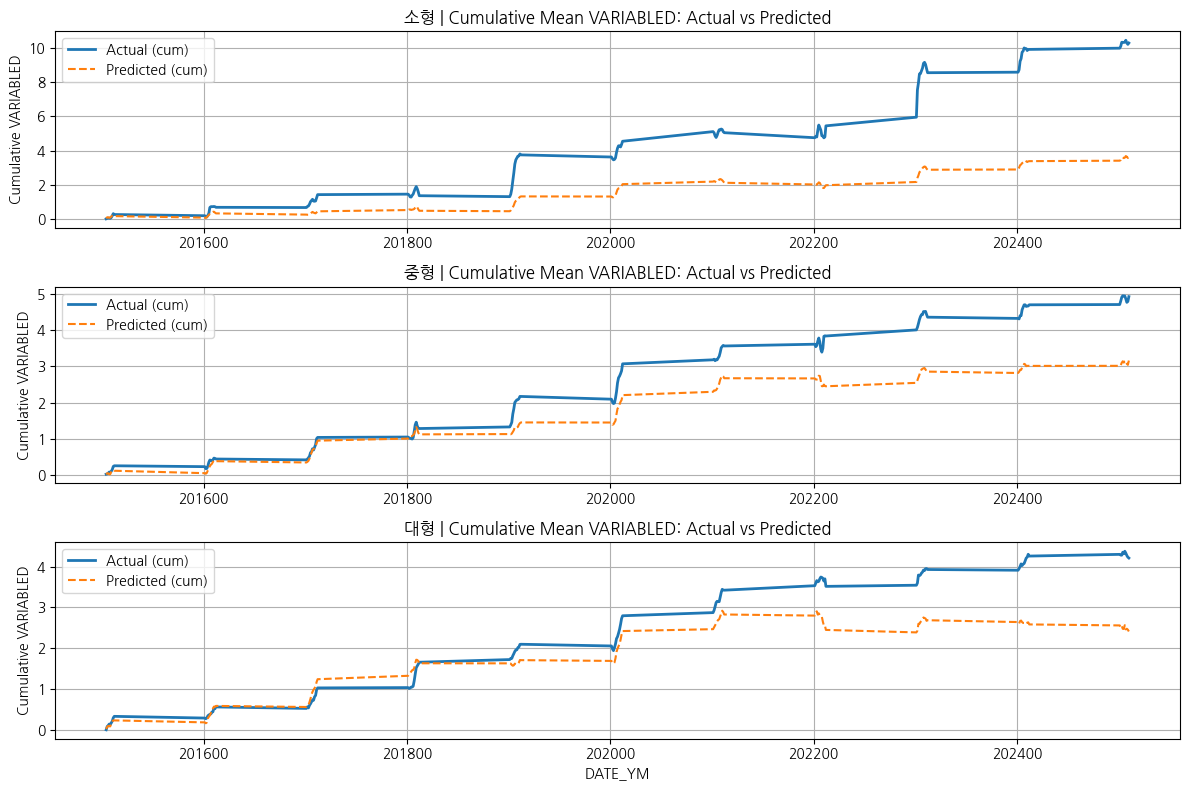

In [12]:
# ============================================
# 전체데이터 예측/시각화 (SVR이 GMM feature 포함 모델일 때)
# 필요 변수:
#   df, svr_model
#   prep_scale, gmm_final, best_k
#   (prep_scale은 GMM용 전처리+스케일, gmm_final은 학습된 GMM)
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams['font.family'] = 'D2Coding'
plt.rcParams['axes.unicode_minus'] = False
rc('font', family='NanumGothic')
df_all = df.copy().sort_values("DATE_YM").reset_index(drop=True)
target = "VARIABLED"

# ----------------------------
# 1) 전체 데이터에서 GMM feature 생성
#    (GMM은 DATE_YM, target 제외하고 학습했었음)
# ----------------------------
X_gmm_all = df_all.drop(columns=["DATE_YM", target])

# (너가 GMM 학습 때 PRICE_MEDIAN 포함/제외한 것과 동일하게 맞춰야 함)
# 만약 GMM 학습 때 PRICE_MEDIAN을 제외했다면 아래 2줄 주석 해제
# if "PRICE_MEDIAN" in X_gmm_all.columns:
#     X_gmm_all = X_gmm_all.drop(columns=["PRICE_MEDIAN"])

Z_all = prep_scale.transform(X_gmm_all)
prob_all = gmm_final.predict_proba(Z_all)
label_all = np.argmax(prob_all, axis=1)

df_all["gmm_label"] = label_all
for i in range(best_k):
    df_all[f"gmm_p{i}"] = prob_all[:, i]

# ----------------------------
# 2) SVR 입력 만들기 (SVR 학습과 동일한 컬럼 구성)
# ----------------------------
X_all = df_all.drop(columns=["DATE_YM", target])

# (SVR 학습 때 PRICE_MEDIAN 제거했으면 동일하게 제거)
if "PRICE_MEDIAN" in X_all.columns:
    X_all = X_all.drop(columns=["PRICE_MEDIAN"])

y_true_all = df_all[target].values
y_pred_all = svr_model.predict(X_all)

df_all["y_true"] = y_true_all
df_all["y_pred"] = y_pred_all

# ----------------------------
# 3) 서울 전체 SIZE별, DATE_YM별 평균 변화율 계산
# ----------------------------
grouped_all = (
    df_all.groupby(["DATE_YM", "SIZE"])
          .agg(y_true_mean=("y_true", "mean"),
               y_pred_mean=("y_pred", "mean"))
          .reset_index()
)

# ----------------------------
# 4) 시각화: 변화율 추이
# ----------------------------
sizes = ["소형", "중형", "대형"]

plt.figure(figsize=(12, 8))
for i, size in enumerate(sizes):
    sub = grouped_all[grouped_all["SIZE"] == size]
    plt.subplot(3, 1, i+1)
    plt.plot(sub["DATE_YM"], sub["y_true_mean"], label="Actual", linewidth=2)
    plt.plot(sub["DATE_YM"], sub["y_pred_mean"], label="Predicted", linestyle="--")
    plt.title(f"{size} | Mean VARIABLED (3M ahead): Actual vs Predicted")
    plt.ylabel("VARIABLED")
    plt.grid(True)
    plt.legend()

plt.xlabel("DATE_YM")
plt.tight_layout()
plt.show()

# ----------------------------
# 5) 시각화: 누적 추이(추천)
# ----------------------------
plt.figure(figsize=(12, 8))
for i, size in enumerate(sizes):
    sub = grouped_all[grouped_all["SIZE"] == size].copy()
    sub["cum_true"] = sub["y_true_mean"].cumsum()
    sub["cum_pred"] = sub["y_pred_mean"].cumsum()

    plt.subplot(3, 1, i+1)
    plt.plot(sub["DATE_YM"], sub["cum_true"], label="Actual (cum)", linewidth=2)
    plt.plot(sub["DATE_YM"], sub["cum_pred"], label="Predicted (cum)", linestyle="--")
    plt.title(f"{size} | Cumulative Mean VARIABLED: Actual vs Predicted")
    plt.ylabel("Cumulative VARIABLED")
    plt.grid(True)
    plt.legend()

plt.xlabel("DATE_YM")
plt.tight_layout()
plt.show()
